In [1]:
import fastjet as fj
from lundplane import pylundplane as lund
from mptools import pymptools as mpt
from tqdm import tqdm
import math
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
plt.style.use('seaborn-whitegrid')
%config InlineBackend.figure_format = 'retina'
from tqdm import tnrange, tqdm_notebook
import os
import re
import numpy as np

In [2]:
def count_events(fname):
    count = 0
    with open(fname) as f:
        contents = f.read()
        count = sum(1 for match in re.finditer(r"\bEND_EVENT\b", contents))
    return count

In [3]:
def thetaC(e, ktmin):
    return np.log(1 / (2.0 * ktmin / e))
def thetaDC(e, m):
    return np.log(1 / (m / e))

In [4]:
aleph_file="/Volumes/two/data/aleph/LEP1Data1992_recons_aftercut-001.aleph"
if not os.path.isfile(aleph_file):
    aleph_file="/Volumes/mp256s/data/aleph/LEP1Data1992_recons_aftercut-001.aleph"
if not os.path.isfile(aleph_file):
    aleph_file="/Users/ploskon/data/aleph/LEP1Data1992_recons_aftercut-001.aleph"
mpt.dump(aleph_file, 2, False);
# mpt.dump(aleph_file, -1, True);

In [5]:
# print the banner first
fj.ClusterSequence.print_banner()
print()
# set up our jet definition and a jet selector
jet_R0 = 0.4
jet_def = fj.JetDefinition(fj.antikt_algorithm, jet_R0)
#jet_selector = fj.SelectorPtMin(0.0) & fj.SelectorPtMax(200.0) & fj.SelectorAbsEtaMax(1)
jet_selector = fj.SelectorPtMin(0.0) & fj.SelectorPtMax(200.0)

In [6]:
%%time
all_jets = []
pbar = tqdm_notebook(total=count_events(aleph_file))
reader = mpt.Reader(aleph_file)
while reader.read_next_event():
    pbar.update()
    e = reader.get_event()
    parts = []
    # aleph_parts = e.get_particles()
    # print(len(aleph_parts))
    for p in e.get_particles():
        psj = fj.PseudoJet(p.px(), p.py(), p.pz(), p.e())
        parts.append(psj)
    jets = jet_selector(jet_def(parts))
    all_jets.extend(jets)

CPU times: user 27.1 s, sys: 714 ms, total: 27.9 s
Wall time: 28.1 s


In [7]:
%%time
jet_def_lund = fj.JetDefinition(fj.cambridge_algorithm, 1.0)
lund_gen = lund.LundGenerator(jet_def_lund)
lunds = [lund_gen.result(j) for j in all_jets]

CPU times: user 1.27 s, sys: 110 ms, total: 1.38 s
Wall time: 1.39 s


In [8]:
%%time
log_kt = []
log_1oDelta = []
for l in lunds:
    for s in l:
        log_kt.append(math.log(s.kt()))
        log_1oDelta.append(math.log(1./s.Delta()))

CPU times: user 1.65 s, sys: 31.3 ms, total: 1.68 s
Wall time: 1.69 s


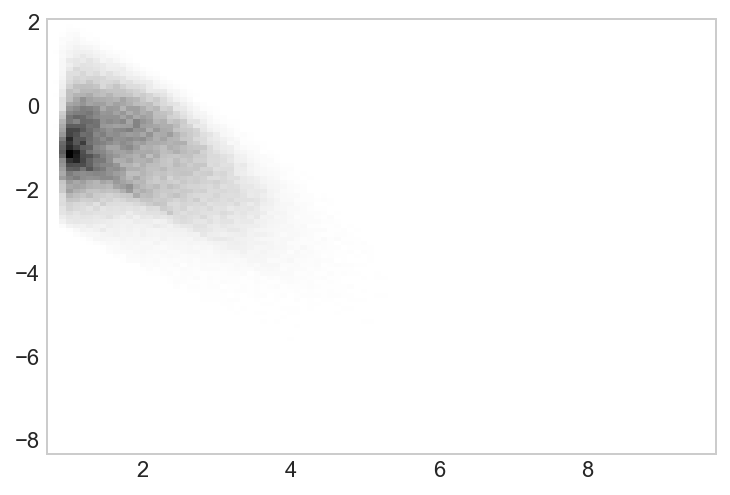

In [9]:
b, x, y, ax = plt.hist2d(log_1oDelta, log_kt, bins=100)

In [10]:
%%time
jet_selector_10 = fj.SelectorPtMin(10.0) & fj.SelectorPtMax(200.0)
jets_10 = jet_selector_10(all_jets)
lunds = [lund_gen.result(j) for j in jets_10]

CPU times: user 904 ms, sys: 170 ms, total: 1.07 s
Wall time: 1.09 s


In [11]:
%%time
log_kt = []
log_1oDelta = []
for l in lunds:
    for s in l:
        log_kt.append(math.log(s.kt()))
        log_1oDelta.append(math.log(1./s.Delta()))

CPU times: user 726 ms, sys: 24.3 ms, total: 750 ms
Wall time: 753 ms


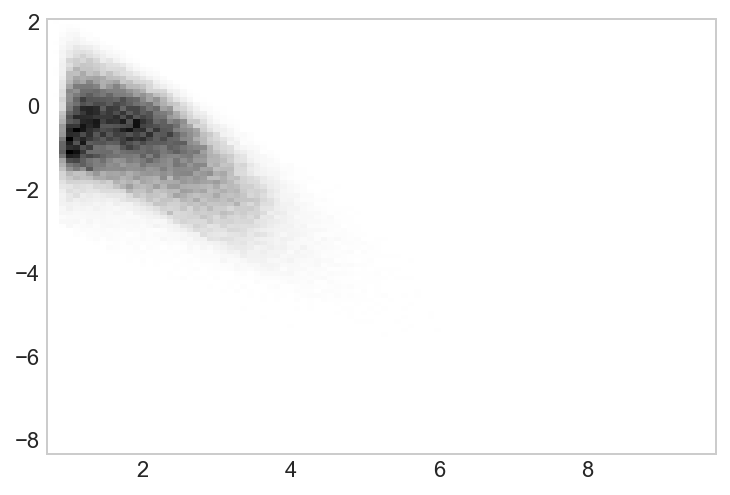

In [12]:
b, x, y, ax = plt.hist2d(log_1oDelta, log_kt, bins=100)

In [13]:
len(jets_10)

29272

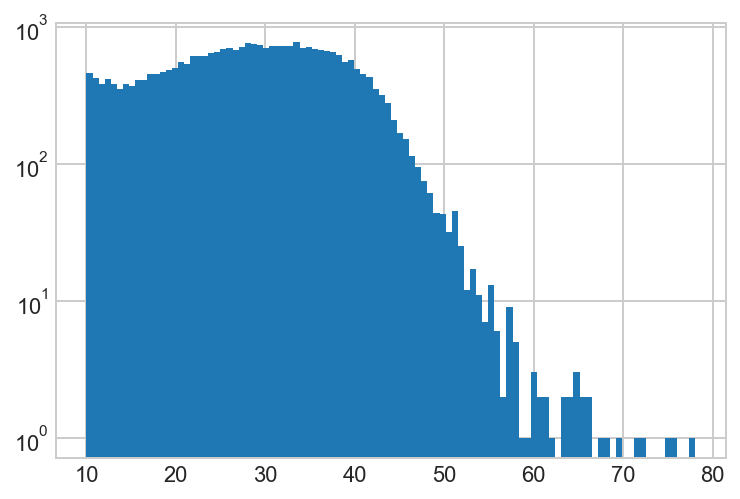

In [14]:
plt.yscale("log")
b, x, ax = plt.hist([j.pt() for j in jets_10], bins=100)

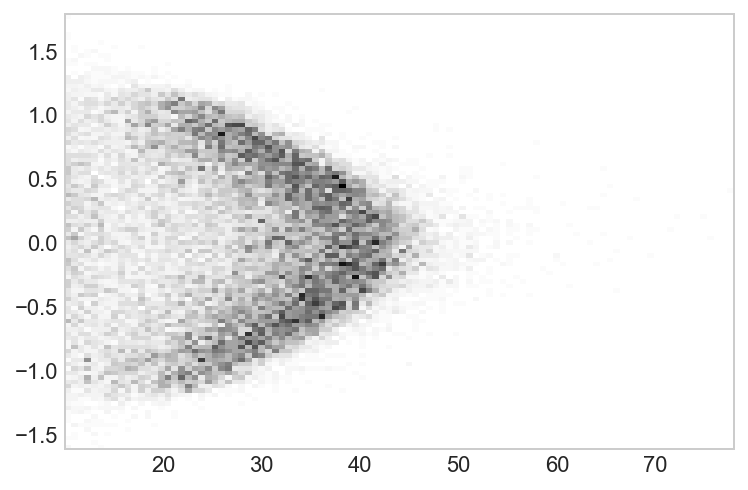

In [15]:
plt.yscale("linear")
b, x, y, ax = plt.hist2d([j.pt() for j in jets_10], [j.eta() for j in jets_10], bins=100)

In [16]:
%%time
jet_selector_20 = fj.SelectorPtMin(20.0) & fj.SelectorPtMax(200.0)
jets_20 = jet_selector_20(all_jets)
lunds_20 = [lund_gen.result(j) for j in jets_20]

CPU times: user 602 ms, sys: 54 ms, total: 656 ms
Wall time: 660 ms


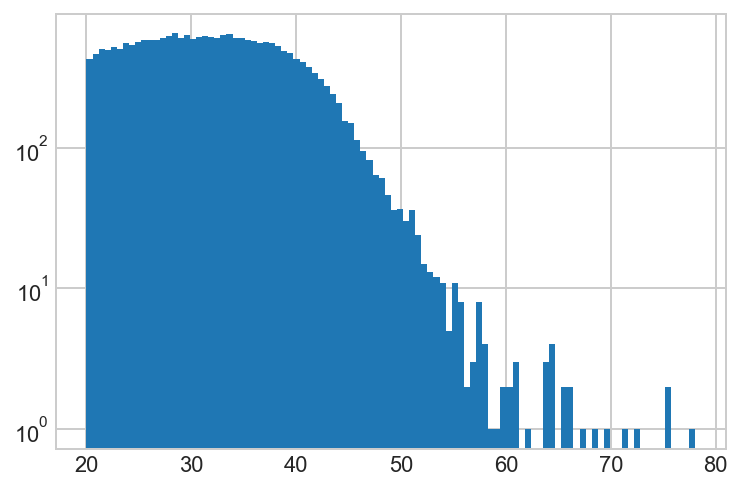

In [17]:
plt.yscale("log")
b, x, ax = plt.hist([j.pt() for j in jets_20], bins=100)

In [18]:
log_kt_20 = []
log_1oDelta_20 = []
for l in lunds_20:
    for s in l:
        log_kt_20.append(math.log(s.kt()))
        log_1oDelta_20.append(math.log(1./s.Delta()))

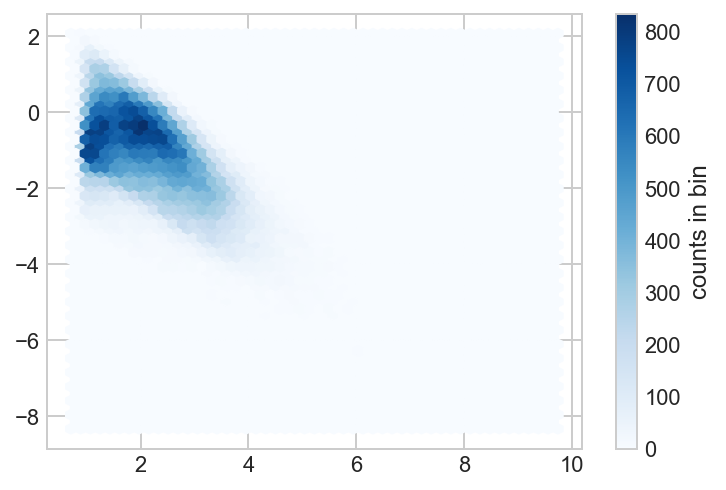

In [19]:
polys = plt.hexbin(log_1oDelta_20, log_kt_20, gridsize=50, cmap='Blues')
cb = plt.colorbar()
cb.set_label('counts in bin')

In [20]:
%%time
e_20_ktcut = []
log_1oDelta_20_ktcut = []
log_kt_20_ktcut = []
for l in lunds_20:
    for s in l:
        if (math.log(s.kt()) > 0):
            log_kt_20_ktcut.append(math.log(s.kt()))
            log_1oDelta_20_ktcut.append(math.log(1./s.Delta()))
            e_20_ktcut.append(s.pair().e())

CPU times: user 603 ms, sys: 7.99 ms, total: 611 ms
Wall time: 613 ms


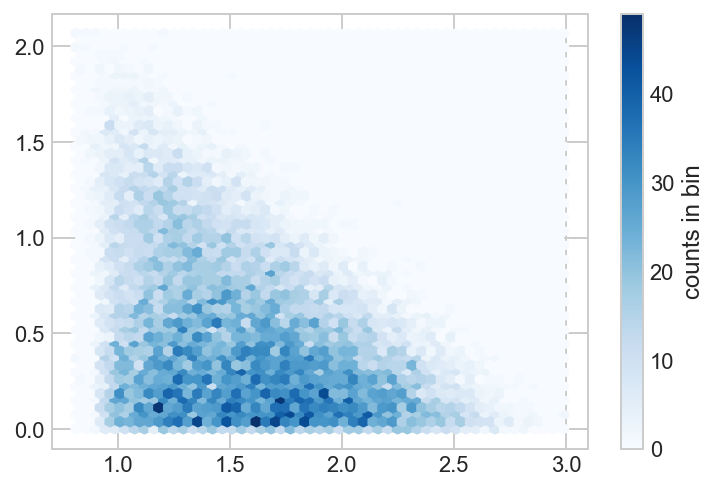

In [21]:
polys = plt.hexbin(log_1oDelta_20_ktcut, log_kt_20_ktcut, gridsize=50, cmap='Blues')
cb = plt.colorbar()
cb.set_label('counts in bin')

Text(0, 0.5, 'ln(1/$\\theta$)')

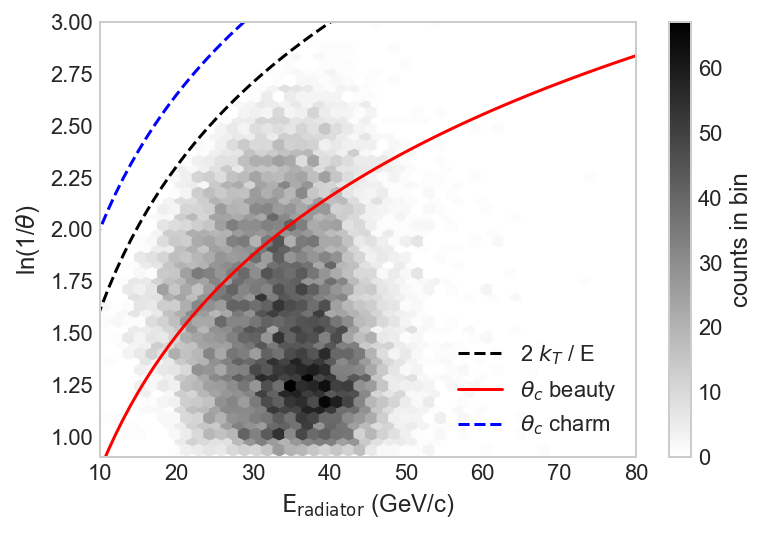

In [25]:
plt.hexbin(e_20_ktcut, log_1oDelta_20_ktcut, gridsize=50, cmap='binary')
er = np.linspace(1, 101., 100)
ax = plt.plot(er, thetaC(er, 1.0), 'k--', thetaDC(er, 4.8), 'r', thetaDC(er, 1.5), 'b--')
cb = plt.colorbar()
cb.set_label('counts in bin')
plt.axis([10, 80, 0.9, 3.0])
plt.legend(ax[:3], [r'2 $k_{T}$ / E', r'$\theta_{c}$ beauty', r'$\theta_{c}$ charm'])
plt.xlabel(r'$\mathrm{E}_\mathrm{radiator}$ (GeV/c)')
plt.ylabel(r'ln(1/$\theta$)')

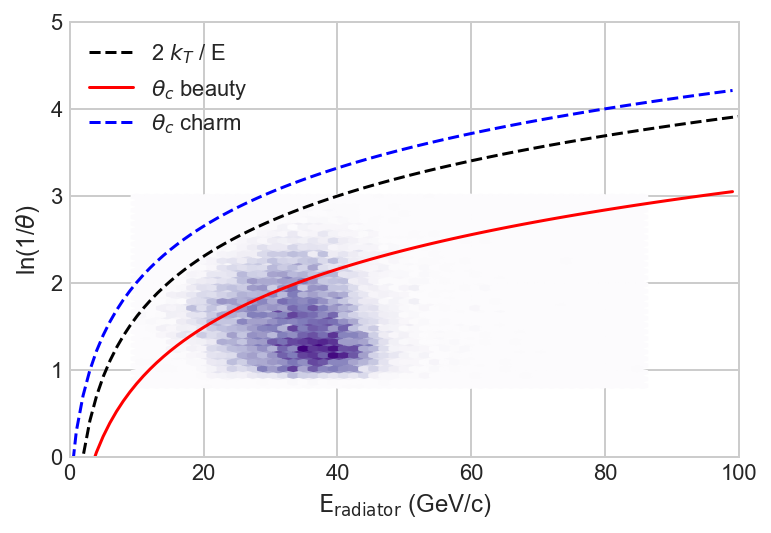

In [26]:
er = np.linspace(1, 101., 100)
ax = plt.plot(er, thetaC(er, 1.0), 'k--', thetaDC(er, 4.8), 'r', thetaDC(er, 1.5), 'b--')
plt.hexbin(e_20_ktcut, log_1oDelta_20_ktcut, gridsize=50, cmap='Purples')
plt.grid(True)
plt.xlabel(r'$\mathrm{E}_\mathrm{radiator}$ (GeV/c)')
plt.ylabel(r'ln(1/$\theta$)')
plt.axis([0, 100, 0, 5.0])
plt.legend(ax[:3], [r'2 $k_{T}$ / E', r'$\theta_{c}$ beauty', r'$\theta_{c}$ charm']);

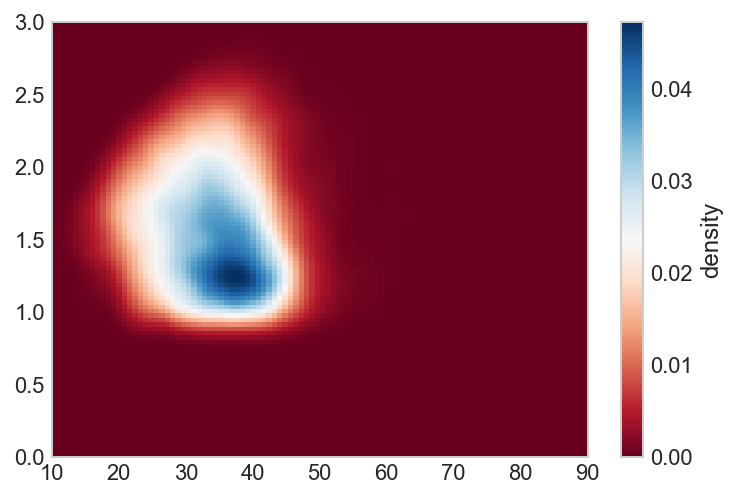

In [24]:
from scipy.stats import gaussian_kde
# fit an array of size [Ndim, Nsamples]
data = np.vstack([e_20_ktcut, log_1oDelta_20_ktcut])
kde = gaussian_kde(data)
# evaluate on a regular grid
xgrid = np.linspace(10, 90, 100)
ygrid = np.linspace(0, 3, 100)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
Z = kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))
# Plot the result as an image
plt.grid(False)
plt.imshow(Z.reshape(Xgrid.shape),
            origin='lower', aspect='auto',
            extent=[10, 90, 0, 3],
            cmap='RdBu')
cb = plt.colorbar()
cb.set_label("density")